# Triplet Loss with Transfer Learning (InceptionV3) Evaluation

In [1]:
%matplotlib notebook

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [2]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
from utils import create_batch, create_testdata, tbProjector, triplet_loss

## Specify model file spcifier

In [5]:
epoch_time = '1600847846' # Change this depending on the model I want to evaluate

model_file = 'siameseN_inceptionV3_{}.h5'.format(epoch_time)
emb_file = 'embeddings_inceptionV3_{}.h5'.format(epoch_time)
tblog_dir = 'logs_eval/logs-{}'.format(epoch_time)

## Check the Number of Test Data

In [6]:
image_dir = "image_data"
emb_size = 128

In [7]:
test_dir = os.path.join(image_dir, "test")
print(test_dir)
print("items = {}".format(len(os.listdir(test_dir))))

image_data/test
items = 89


In [8]:
all_images_test = 0
class_list_test = sorted(os.listdir(test_dir))
for i in class_list_test:
    #print(i)
    all_images_test += len(os.listdir(os.path.join(test_dir, i)))
print("All test image files = {}".format(all_images_test))
#print("class_list[:10] = {}".format(class_list[:10]))

All test image files = 1447


## Evaluation metrics

- `VAL` : The proportion of "anchor - positive" pairs which are closer than the threshold over all "anchor - positive" pairs
- `FAR` : The proportion of "anchor - negative" pairs which are closer than the threshold over all "anchor - negative" pairs

In [9]:
# For tensorflow (When using these metrics during training)

_DIST_THRD = 0.1

def metrics_val(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    
    # Count the number of all test data
    all_mask = tf.math.greater_equal(positive_dist, tf.constant([0.]))
    all_num = tf.cast(all_mask, tf.float32)
    
    positive_dist_led = tf.math.less_equal(positive_dist, tf.constant([_DIST_THRD]))
    positive_dist_led_num = tf.cast(positive_dist_led, tf.float32)
    
    val = tf.math.divide(positive_dist_led_num, all_num)
    
    return val


def metrics_far(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    all_mask = tf.math.greater_equal(negative_dist, tf.constant([0.]))
    all_num = tf.cast(all_mask, tf.float32)
    
    negative_dist_led = tf.math.less_equal(negative_dist, tf.constant([_DIST_THRD]))
    negative_dist_led_num = tf.cast(negative_dist_led, tf.float32)
    
    far = tf.math.divide(negative_dist_led_num, all_num)
    
    return far

In [10]:
def eval_val(pred, thrd=0.1):
    """ Calculate VAL and FAR from prediction.
        Return: Tuple of (VAL, FAR)
    """
    
    anchor, positive, negative = pred[:,:emb_size], pred[:,emb_size:2*emb_size], pred[:,2*emb_size:]
    pos_dist = np.mean((anchor - positive)**2, axis=1)
    neg_dist = np.mean((anchor - negative)**2, axis=1)
    
    pos_dist_let = pos_dist <= thrd
    cnt_pos_let = np.sum(pos_dist_let.astype(int))
    neg_dist_let = neg_dist <= thrd
    cnt_neg_let = np.sum(neg_dist_let.astype(int))
    
    return (cnt_pos_let/pred.shape[0], cnt_neg_let/pred.shape[0])

## Load Saved Models

In [11]:
from tensorflow.keras.models import load_model

net = load_model(model_file, compile=False)
net.compile(loss=triplet_loss, optimizer='adam')

#net = load_model('siameseN_inceptionV3_1600847846.h5')

## Prediction

In [12]:
x_eval = create_batch(256, 'test')
print(x_eval[0].shape)

(256, 224, 224, 3)


In [13]:
test_out = net.predict(x_eval)
print(test_out.shape)

(256, 384)


## Find the best threshold

In [14]:
for i in np.linspace(0.1, 0.5, 5):
    _val, _far = eval_val(test_out, i)
    print("thrd(d) = {:2f}, val = {}, far = {}".format(i, _val, _far))

thrd(d) = 0.100000, val = 0.37109375, far = 0.03125
thrd(d) = 0.200000, val = 0.71484375, far = 0.1015625
thrd(d) = 0.300000, val = 0.87109375, far = 0.23046875
thrd(d) = 0.400000, val = 0.953125, far = 0.421875
thrd(d) = 0.500000, val = 0.98046875, far = 0.6796875


In [15]:
for i in np.linspace(0.2, 0.29, 10):
    _val, _far = eval_val(test_out, i)
    print("thrd(d) = {:2f}, val = {}, far = {}".format(i, _val, _far))

thrd(d) = 0.200000, val = 0.71484375, far = 0.1015625
thrd(d) = 0.210000, val = 0.7421875, far = 0.11328125
thrd(d) = 0.220000, val = 0.765625, far = 0.11328125
thrd(d) = 0.230000, val = 0.7734375, far = 0.1171875
thrd(d) = 0.240000, val = 0.7890625, far = 0.125
thrd(d) = 0.250000, val = 0.796875, far = 0.13671875
thrd(d) = 0.260000, val = 0.80859375, far = 0.15234375
thrd(d) = 0.270000, val = 0.8359375, far = 0.171875
thrd(d) = 0.280000, val = 0.8515625, far = 0.1875
thrd(d) = 0.290000, val = 0.86328125, far = 0.21875


## See embeddings by Tensorboard

In [16]:
emb_model = load_model(emb_file)
emb_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
Total params: 22,917,536
Trainable params: 1,114,752
Non-trainable params: 21,802,784
_________________________________________

In [17]:
tblog_dir_abs = os.path.abspath(tblog_dir)
if not os.path.exists(tblog_dir_abs):
    os.makedirs(tblog_dir_abs)
    
tb_metadata = 'metadata.tsv'
emb_test_data = create_testdata(tblog_dir=tblog_dir_abs, metadatafile=tb_metadata, seed=46)
emb_test_data_y = np.zeros((emb_test_data.shape[0], emb_size))

In [18]:
tbp = tbProjector(emb_model, emb_test_data, emb_test_data_y, tblog_dir_abs, tb_metadata)

In [19]:
tbp.output()

In [20]:
print("$ tensorboard --logdir={}".format(tblog_dir))
#!tensorboard --logdir=$tblog_dir_abs

$ tensorboard --logdir=logs_eval/logs-1600847846


## Class - Color mapping in Tensorboard

In [21]:
import csv
from collections import defaultdict

tb_class = defaultdict(int)
with open(os.path.join(tblog_dir, tb_metadata)) as f:
    rd = csv.reader(f, delimiter="\t", quotechar='"')
    for line in rd:
        tb_class[line[0]] += 1

In [22]:
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

color_name = ['steelblue', 'crimson', 'hotpink', 'mediumturquoise', 'forestgreen', 'sienna', 'darkkhaki', 'darkorange', 'mediumpurple', 'grey']
labels = list(tb_class.keys())

In [23]:
# Color - directory(class) mapping
#fig, ax = plt.subplots(figsize=(5, 3))
#X, Y = fig.get_dpi() * fig.get_size_inches()
#nrows = len(labels)
#h = Y / (nrows + 1)

#for i, cn in enumerate(color_name):
#    
#    y = Y - (i * h) - h
#
#    ax.text(30, y, labels[i], fontsize=(h*0.5), horizontalalignment='left',
#            verticalalignment='center')
#    ax.hlines(y + h * 0.1, 0, 20,
#              color=colors[color_name[i]], linewidth=(h * 0.5))
#
#ax.set_xlim(0, X)
#ax.set_ylim(0, Y)
#ax.set_axis_off()
#
#plt.show()

<IPython.core.display.Javascript object>


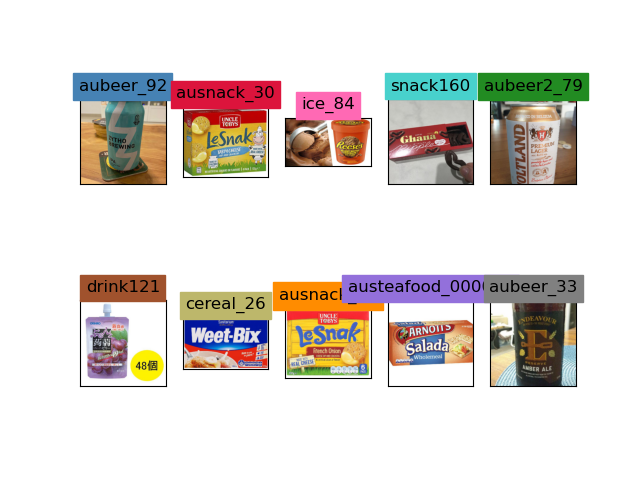

In [24]:
_row = 2
_col = 5
fig, axs = plt.subplots(2, 5)

for i, label in enumerate(labels):
    label_dir = os.path.join(test_dir, label)
    item_list = os.listdir(label_dir)
    img = tf.keras.preprocessing.image.load_img(os.path.join(label_dir, item_list[0]))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    axs[i//_col, i%_col].imshow(img)
    axs[i//_col, i%_col].set_title(label, backgroundcolor= colors[color_name[i]])
    axs[i//_col, i%_col].set_xticks([])
    axs[i//_col, i%_col].set_yticks([])

plt.xticks([])
plt.yticks([])
plt.show()

## Test 

Make a list that has image embeddings from each class in test directory. The image converted and stored in this list has been selected as it most represents the class(item).

Then I will randomly choose some images from test directory and predict the item by searching the image embeddings list. The item in the list which has the least distance to the target image is supposed to most likely be the class the target image belongs to. 

In [25]:
#test_embimg_list = []
#testdir_list = os.listdir(test_dir)

#for i, td in enumerate(testdir_list):
#    td_path = os.path.join(test_dir, td)
    # Get the first image in the directory as an embedding
#    img_file = os.path.join(td_path, sorted(os.listdir(td_path))[0])
#    test_embimg_list.append(img_file)

#with open('embeddings_list.txt', 'w') as wf:
#    for line in test_embimg_list:
#        wf.write("{}\n".format(line))

In [26]:
# embeddings_list.txt contains the paths of images that most represent each class it belongs to 
with open('embeddings_list.txt', 'r') as rf:
    emb_list = rf.readlines()

In [27]:
emb_list = [ el.strip('\n') for el in emb_list]
#print(emb_list)

<IPython.core.display.Javascript object>


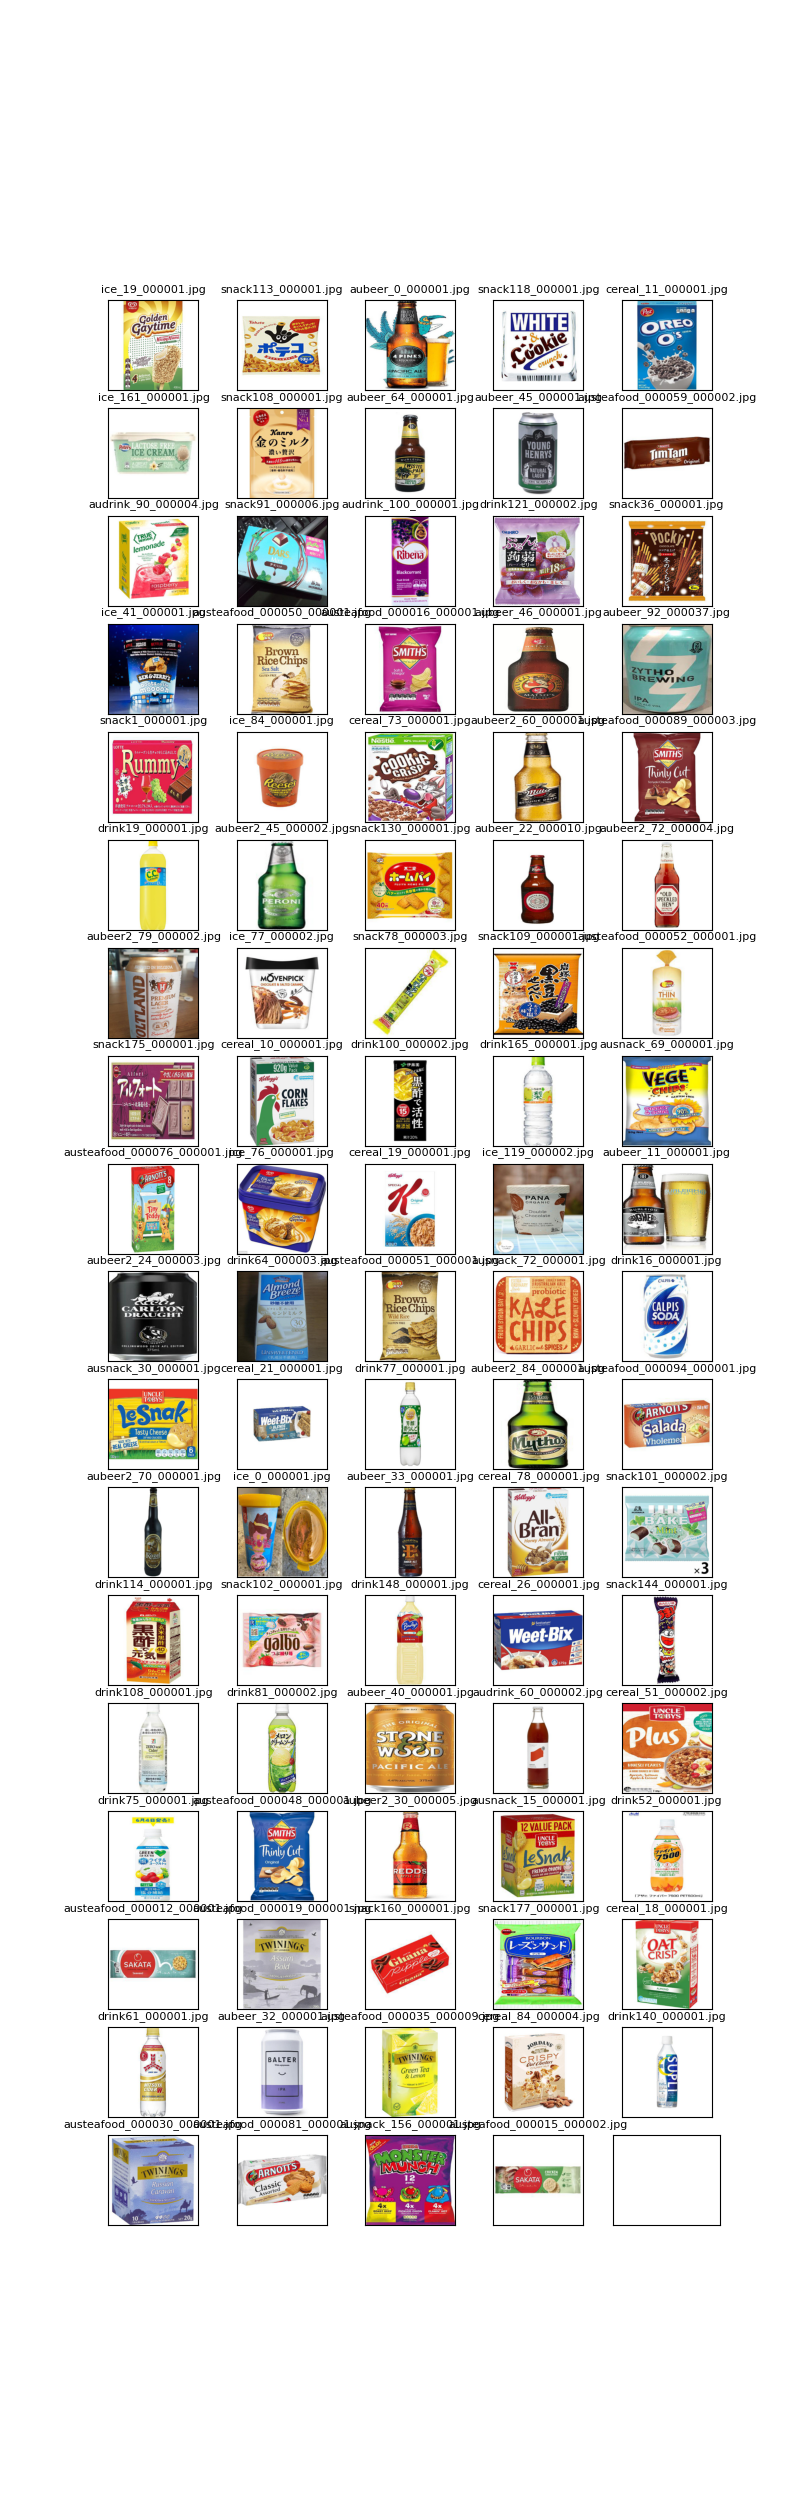

In [35]:
testdir_list = os.listdir(test_dir)

_row = ((len(testdir_list) - 1) // 5) + 1 
_col = 5
fig2, axs2 = plt.subplots(_row, 5, figsize=(8,25))

for i, el in enumerate(emb_list):
    
    img = tf.keras.preprocessing.image.load_img(el)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    
    #img_input = np.expand_dims(img, axis=0) 
    #test_embeddings_list[i] = emb_model.predict(img_input)
    
    axs2[i//_col, i%_col].imshow(img)
    axs2[i//_col, i%_col].set_title(el.split('/')[-1], fontsize=8)
    axs2[i//_col, i%_col].set_xticks([])
    axs2[i//_col, i%_col].set_yticks([])
    
plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
plt.close(fig2)

In [30]:
embeddings_list = np.zeros((len(testdir_list), emb_size))

#testdir_list = os.listdir(test_dir)

for i, img_file in enumerate(emb_list):
    
    img = tf.keras.preprocessing.image.load_img(img_file)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    
    img_input = np.expand_dims(img, axis=0) 
    embeddings_list[i] = emb_model.predict(img_input)
    

In [31]:
def matching(target_img, thrd=0.28, count=1):
    '''
    target_img : Array of an image, size of (224, 224, 3), normalized by /= 255.
    thrd : threshold of the distance(squared) identified as positive (positive <= threshold)
    count : The maximum number of positives to be returned as matched embeddings
    
    Return : Indices of embeddings_list that identified as positive (Top one is the most likely to be the same)
    '''
    
    target_img = np.expand_dims(target_img, axis=0)
    target_emb = emb_model.predict(target_img)
    
    distance = np.mean((embeddings_list - target_emb)**2, axis=1)
    pos_arg = np.argwhere(distance <= thrd)
    pos_arg_sort_idx = np.argsort(distance[pos_arg], axis=None)
    pos_arg_sorted = pos_arg[pos_arg_sort_idx]
    
    if pos_arg_sorted.shape[0] <= count:
        return pos_arg_sorted[:]
    
    else:
        return pos_arg_sorted[:count]

In [42]:
emb_class_name = [ ec.split('/')[-2] for ec in emb_list ]
emb_file_name = [ ec.split('/')[-1] for ec in emb_list ]

test_size = 10
rng = default_rng()
rand_class = rng.choice(class_list_test, test_size, replace=False)

target_list = []
returned_list = []

for i, cls in enumerate(rand_class):
    
    # Do not choose the identical image as the one in embeddings_list
    idx = emb_class_name.index(cls)
    emb_img = emb_file_name[idx]
    
    target_dir = os.path.join(test_dir, cls)
    imglist = os.listdir(target_dir)
    
    rand_img = rng.choice(imglist, 2, replace=False)
    rand_img = rand_img[rand_img != emb_img]
        
    target_img_file = os.path.join(target_dir, rand_img[0])
    
    img = tf.keras.preprocessing.image.load_img(target_img_file)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    
    returned_classes = matching(img, count=5)
    
    target_list.append(img)
    returned_list.append(returned_classes)

In [43]:
print("target_list size = {}, returned_list size = {}".format(len(target_list), len(returned_list)))

target_list size = 10, returned_list size = 10


<IPython.core.display.Javascript object>


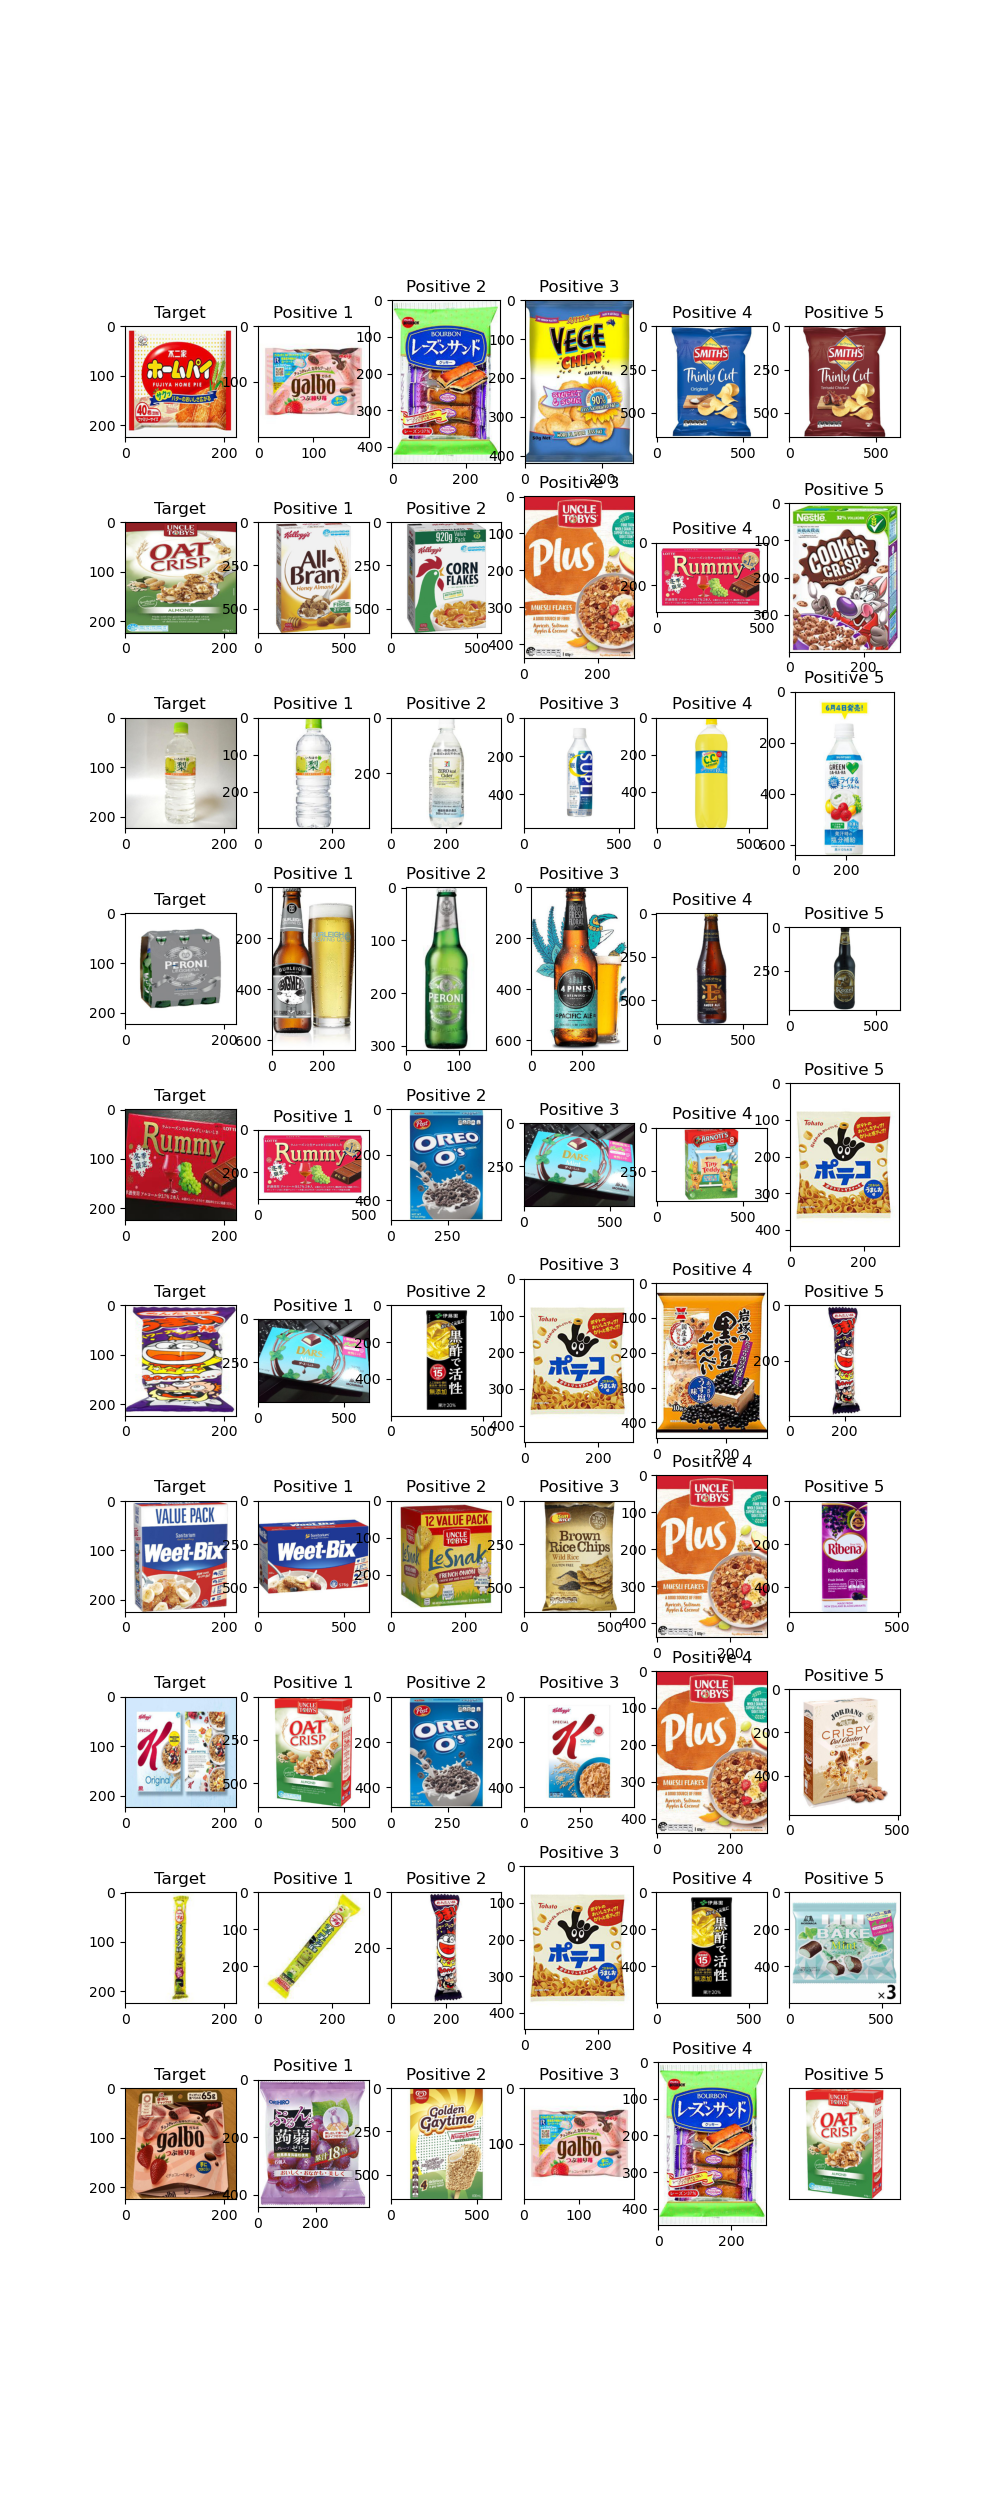

In [44]:
_row = 10
_col = 6

fig, axs = plt.subplots(_row, _col, figsize=(10,25))

for i in range(len(target_list)):
    #label_dir = os.path.join(test_dir, label)
    #item_list = os.listdir(label_dir)
    #img = tf.keras.preprocessing.image.load_img(os.path.join(label_dir, item_list[0]))
    #img = tf.keras.preprocessing.image.img_to_array(img)
    #img /= 255.
    axs[i, 0].imshow(target_list[i])
    axs[i, 0].set_title('Target')
    
    for j in range(len(returned_list[i])):
        img1_file = emb_list[np.squeeze(returned_list[i])[j]]
        img1 = tf.keras.preprocessing.image.load_img(img1_file)
        img1 = tf.keras.preprocessing.image.img_to_array(img1)
        img1 /= 255.
        axs[i, j + 1].imshow(img1)
        axs[i, j + 1].set_title('Positive {}'.format(j + 1))

plt.xticks([])
plt.yticks([])
plt.show()

## Discussion

Generally, with respect to 7 to 8 out of 10 samples, the representative embedding from the same class as the target was detected as top 5 positives. I don't think this will be a satisfactory level.

For further improvement:

- At planning of the model creation, I might have needed to decide which image recognition I would focus on: only the label or the logo of the item, or the entire shape and package of the item. I actually didn't know which I should do before I started this triplet-loss image recognition project, so I just started with images with quite a lot of variation of a specific item/product. For example, a beer has images of cans, bottles, six packs, glasses, only logo, with other goods, etc.  This trained model seems it identifies the similarlities based on the information from the entire image (i.e. shapes, colours, objects...), but at the same time it also recognises the labels (logos, signs) to some extent. It looks like it makes the purpose of this model out of focus, and makes the ability of the model dull.

    To solve this problem, I need to collect appropriate training images. If I want to make a model which detect the item/product itself, I should use only bottle images of the beer for a bottle beer. Or, if I want to detect the label of the item, I should use the training data which contains only images of the label area.
    

- I might need more size of training data.


- It might have been better to use the larger batch size. *Triplet loss and siamese network project from Coursera* used 1024 batch size. However, my machine couldn't load that batch size. 


- I will be able to improve the model architecture, and could do fine-tuning as well.
